# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Usage
Copy this Notebook to "work" folder in your allready installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git)

**This notebook isn't complete.**
If you find some bugs, have problems with some tracks or something else
please report to @Kire in [AWS Machine Learning Community](https://aws-ml-community.slack.com) on #Slack

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [1]:
#!docker logs --tail all $(docker ps | awk ' /sagemaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-sagemaker_50.log 2>&1
#!docker logs --tail all $(docker ps | awk ' /robomaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-robomaker_50.log 2>&1

#EPISODES_PER_ITERATION = 20 #  Set to value of your hyperparameter in training
EPISODES_PER_ITERATION = 40 #  Set to value of your hyperparameter in training


In [2]:
# AWS DeepRacer Console
# stream_name = 'training-20201115184803-ehYPVaEJRxG-V3oc62Te_Q-robomaker' ## CHANGE This to your simulation application ID
fname = 'logs/local-robomaker_50.log'  # The log will be downloaded into the specified path
fname

'logs/local-robomaker_50.log'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
#from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    PlottingUtils as pu,\
    AnalysisUtils as au   #, \
    #   ActionBreakdownUtils as abu,\
    #   NewRewardUtils as nr, \ 

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500, 'display.max_columns', None)

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [4]:
tu = TrackIO()

for f in tu.get_tracks():
    print(f)

AWS_track.npy
Albert.npy
AmericasGeneratedInclStart.npy
Aragon.npy
Austin.npy
Belille.npy
Bowtie_track.npy
Canada_Eval.npy
Canada_Training.npy
ChampionshipCup2019_track.npy
China_eval_track.npy
China_track.npy
FS_June2020.npy
H_track.npy
July_2020.npy
LGSWide.npy
London_Loop_Train.npy
Mexico_track.npy
Mexico_track_eval.npy
Monaco.npy
Monaco_building.npy
New_York_Eval_Track.npy
New_York_Track.npy
Oval_track.npy
Singapore.npy
Singapore_building.npy
Singapore_f1.npy
Spain_track.npy
Spain_track_f1.npy
Straight_track.npy
Tokyo_Training_track.npy
Vegas_track.npy
Virtual_May19_Train_track.npy
reInvent2019_track.npy
reInvent2019_wide.npy
reInvent2019_wide_mirrored.npy
reinvent_base.npy


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 235 waypoints


<AxesSubplot:>

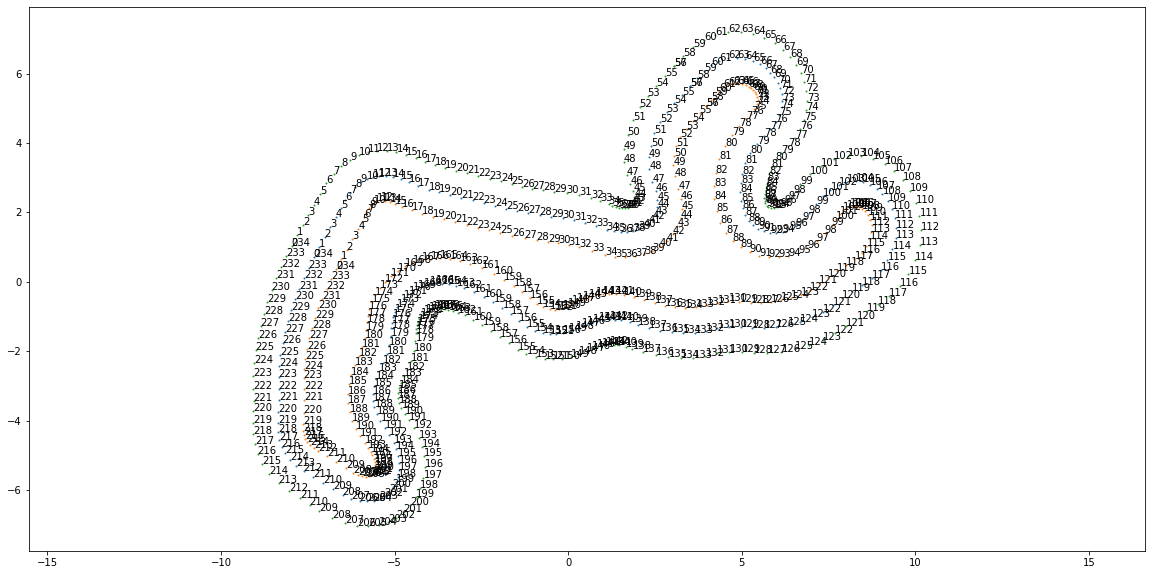

In [5]:
track: Track = tu.load_track("Monaco")
 
l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [6]:
# AWS DeepRacer Console
#stream_name = 'sim-test' ## CHANGE This to your simulation application ID
#fname = 'logs/%s.log' %stream_name  # The log will be downloaded into the specified path
#cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat


# DeepRacer for Dummies / ARCC repository - comment the above and uncomment
# the lines below. They rely on a magic command to list log files
# ordered by time and pick up the most recent one (index zero).
# If you want an earlier file, change 0 to larger value.
# !ls -t /workspace/venv/logs/*.log
# fname = !ls -t /workspace/venv/logs/*.log
# fname = fname[0]


# Chris Rhodes' repository
# Use a preferred way of saving the logs to a file , then set an fname value to load it
# fname = /path/to/your/log/file

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [7]:
!ls logs

local-202011180747-robomaker.log
local-202011180747-sagemaker.log
local-202011180957-robomaker.log
local-202011180957-sagemaker.log
local-202011181420-robomaker.log
local-202011181420-sagemaker.log
local-202011181936-robomaker.log
local-202011181936-sagemaker.log
local-202011190453-robomaker.log
local-202011190453-sagemaker.log
local-202011191339-robomaker.log
local-202011191339-sagemaker.log
local-202011191801-robomaker.log
local-202011191801-sagemaker.log
local-202011192058-robomaker.log
local-202011192058-sagemaker.log
local-202011200448-robomaker.log
local-202011200448-sagemaker.log
local-202011200504-robomaker.log
local-202011200504-sagemaker.log
local-202011201523-robomaker.log
local-202011201523-sagemaker.log
local-202011201935-robomaker.log
local-202011201935-sagemaker.log
local-202011210443-robomaker.log
local-202011210443-sagemaker.log
local-202011211318-robomaker.log
local-202011211318-sagemaker.log
local-202011212137-robomaker.log
local-202011212137-sagemaker.log
local-2020

In [8]:
#fname = 'logs/local-202011301951-robomaker.log'

In [9]:

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
#nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

In [10]:
df['throttle'].mean()

1.9712066637028798

In [11]:
df[['iteration', 'steer', 'throttle']].groupby("iteration").mean()

steer  throttle
iteration                    
1         -2.602071  1.991715
2         -2.800769  1.968914
3         -2.974437  1.952996
4         -2.601503  1.983353
5         -2.368449  1.946192
6         -2.634964  2.002372
7         -3.196685  1.979487
8         -2.449163  1.978563
9         -2.583296  1.921754
10        -2.709286  1.960683
11        -2.686813  2.020696
12        -2.438163  1.956501
13        -2.640839  1.927781
14        -2.660058  1.981134
15        -2.362136  1.967836
16        -2.600912  1.929276
17        -2.684398  1.956925
18        -2.753270  2.016335
19        -2.744542  1.984886
20        -2.205565  1.986490
21        -2.725583  1.950183
22        -2.785087  2.014296
23        -3.072256  2.029585
24        -2.599074  1.945028
25        -2.376788  1.994984
26        -2.181690  1.988693
27        -2.846157  1.951009
28        -2.773598  1.906944
29        -3.178808  2.024712
30        -2.916660  1.947386
31        -2.916986  1.959001
32        -2.603395  1.995085
33        -2.646087  1.992590
34        -2.854751  1.953469
35        -3.160867  1.963107
36        -2.674171  1.965348
37        -3.290890  2.005797
38        -2.735584  1.990912
39        -2.843108  1.982112
40        -2.831369  1.949648
41        -3.053246  1.980033
42        -2.791694  1.942124
43        -2.583143  1.925475
44        -2.398148  1.962668
45        -2.586368  1.992063
46        -2.662198  1.948558
47        -2.467296  1.950740
48        -2.772300  1.966633
49        -2.295341  1.932610
50        -2.408150  1.940439
51        -2.419959  1.949011
52        -2.722453  1.941178
53        -2.999574  1.933902
54        -2.791410  1.971805
55        -2.998506  1.954062
56        -2.586938  1.926407
57        -3.163533  1.968957
58        -2.460490  1.960270
59        -2.224601  1.940950
60        -2.871824  1.955807
61        -3.249465  1.967264
62        -2.531945  1.969922
63        -3.065658  1.966600
64        -2.951106  1.964548
65        -2.118305  1.935684
66        -2.911343  1.933072
67        -3.065736  1.940708
68        -2.525035  1.971226
69        -2.894571  1.993111
70        -3.490000  1.970571
71        -2.711394  1.979891
72        -2.643278  1.950080
73        -2.261178  1.942588
74        -2.896776  2.050233
75        -2.519504  1.981190
76        -2.586273  1.973547
77        -2.337253  1.977174
78        -2.304640  1.974240
79        -2.987489  1.963575
80        -2.447323  2.012659
81        -2.418389  1.977120
82        -2.641097  1.958844
83        -2.912797  1.960851
84        -2.865882  1.955418
85        -2.005969  1.919825
86        -3.200064  1.959751
87        -2.580519  1.992489
88        -2.464333  1.963640
89        -2.837199  1.952663
90        -2.388885  2.008244
91        -3.011528  1.930585
92        -2.784529  1.972686
93        -2.252346  1.965931
94        -2.847098  1.947932
95        -2.043285  1.981811
96        -2.606940  1.995031
97        -2.721674  1.978415
98        -2.672209  1.967864
99        -2.768167  1.977784
100       -2.365538  1.989978
101       -2.770414  1.968454
102       -3.097214  1.934506
103       -3.055630  1.979540
104       -2.807308  1.913310
105       -2.742365  1.982440
106       -3.243538  1.937001
107       -2.820468  1.938488
108       -2.736231  1.933718
109       -2.632823  1.962318
110       -3.075881  1.968451
111       -2.500232  1.971719
112       -2.318737  1.970674
113       -2.621375  1.964321
114       -2.342759  1.968923
115       -2.687247  1.976282
116       -2.639475  1.954238
117       -2.495224  1.953054
118       -2.875914  1.955595
119       -2.483531  1.999091
120       -3.023255  1.912718
121       -2.670529  1.935264
122       -2.384957  1.946048
123       -2.687471  1.968645
124       -3.216749  1.967560
125       -2.536098  1.950241
126       -3.222451  1.937805
127       -2.713217  2.007249
128       -2.179010  1.975740
129       -2.807172  1.995426
130       -2.590696  1.938063
131       -2.872785  1.931573
132       -2.529235  2.0

new reward not found, using reward as its values
Number of episodes =  7146
Number of iterations =  179


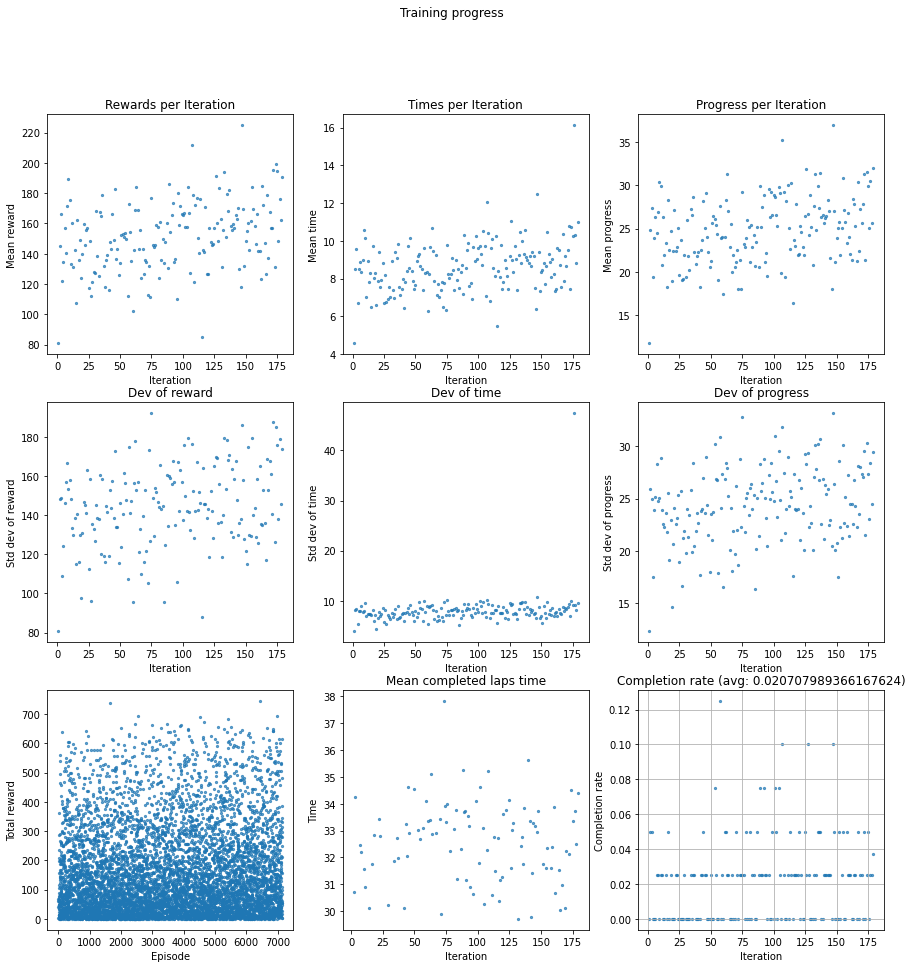

<Figure size 432x288 with 0 Axes>

In [12]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title='Training progress')

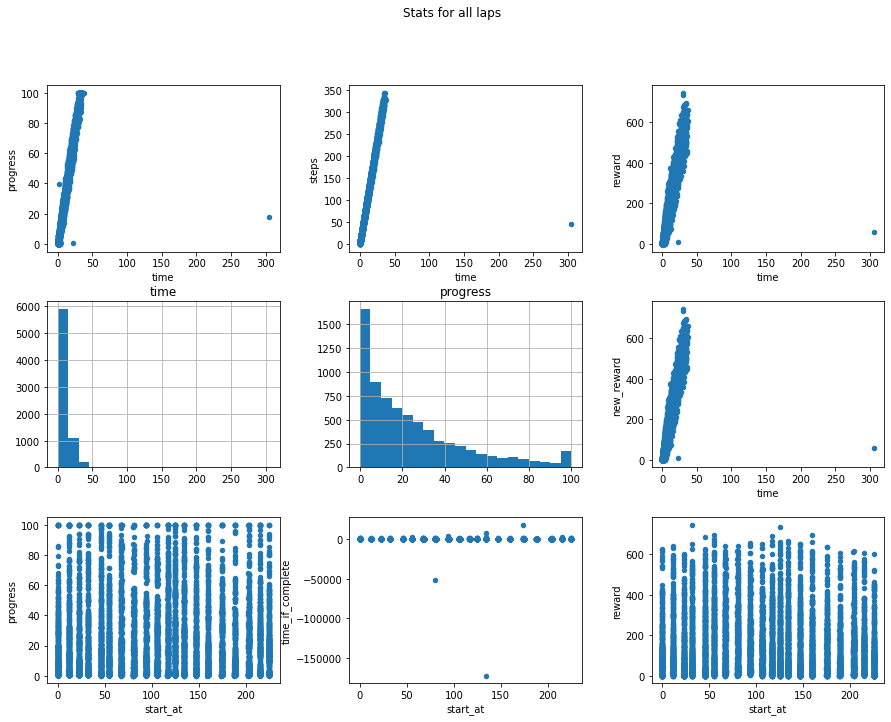

<Figure size 432x288 with 0 Axes>

In [13]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

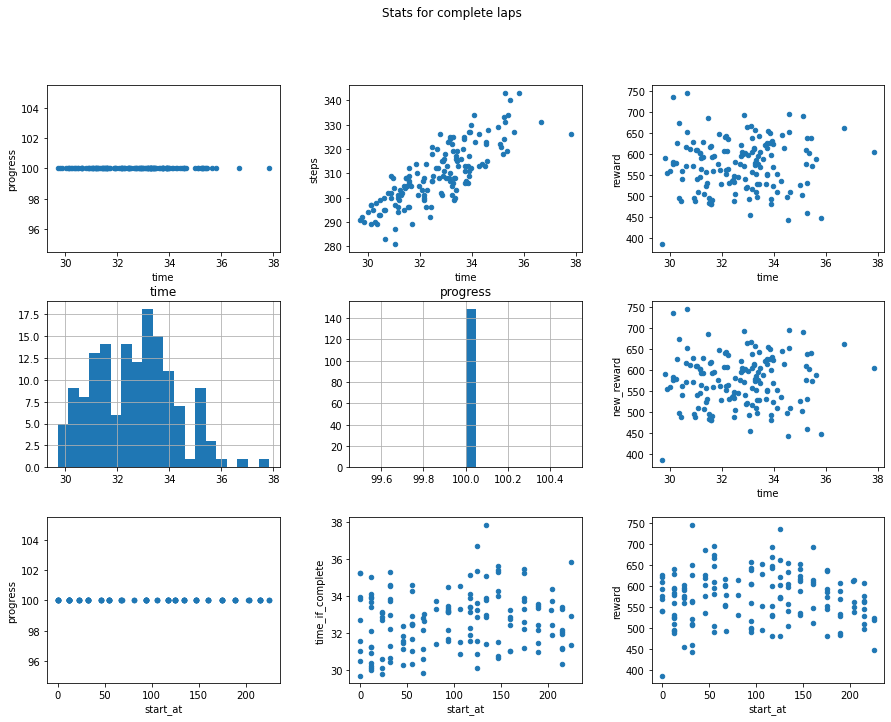

<Figure size 432x288 with 0 Axes>

In [14]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [15]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(50, 'reward')

iteration  episode  steps  start_at  progress       time  new_reward  \
6423        161     6423    295        32     100.0  30.659718    745.3749   
1651         42     1651    297       125     100.0  30.116710    736.5936   
6965        175     6965    315        55     100.0  34.575130    694.2886   
2554         64     2554    301       160     100.0  32.861791    692.8354   
4510        113     4510    321       117     100.0  35.120171    691.5502   
5404        136     5404    308        46     100.0  31.468766    684.9370   
4665        117     4665    289        55     100.0  30.364124    673.7485   
2450         62     2450    308       117     100.0  33.136944    667.9447   
3465         87     3465    316        55     100.0  32.950247    665.5695   
3931         99     3931    331       125     100.0  36.686154    662.0008   
5088        128     5088    325        94     100.0  33.280278    657.2365   
3292         83     3292    307       134     100.0  33.771432    654.1080   
1989         50     1989    323       106     100.0  34.567981    653.1682   
6673        167     6673    283       147     100.0  30.657535    652.8070   
4123        104     4123    313        32     100.0  33.859914    650.8325   
5870        147     5870    310       117     100.0  31.893317    647.0194   
4125        104     4125    313        55     100.0  34.302495    646.4361   
870          22      870    319       117     100.0  33.436753    643.8240   
6848        172     6848    301        94     100.0  32.160290    643.5996   
6841        172     6841    307        12     100.0  32.123661    641.4228   
113           3      113    334       147     100.0  35.417723    639.4526   
5788        145     5788    310        94     100.0  33.171123    638.7544   
3515         88     3515    324       175     100.0  35.262097    637.9650   
6075        152     6075    314       175     100.0  32.247395    636.7860   
2252         57     2252    311       134     100.0  33.916625    632.2571   
3729         94     3729    309       106     100.0  30.884572    629.6968   
6041        152     6041    301        12     100.0  31.271244    629.0005   
4164        105     4164    290        46     100.0  30.271602    626.2264   
2260         57     2260    306         0     100.0  33.868134    626.2010   
4863        122     4863    313        32     100.0  33.753017    625.3570   
3013         76     3013    312       147     100.0  33.981247    623.3074   
2451         62     2451    320       125     100.0  33.653119    622.5223   
4620        116     4620    308         0     100.0  32.732667    621.6634   
6124        154     6124    307        46     100.0  31.594982    620.2340   
6533        164     6533    296       147     100.0  31.539820    616.9828   
3826         96     3826    300        67     100.0  30.633133    615.9093   
1714         43     1714    301       160     100.0  33.255149    614.7787   
7137        179     7137    314       204     100.0  34.403673    614.6420   
7047        177     7047    311        81     100.0  33.739295    614.4367   
3217         81     3217    305       203     100.0  33.246199    612.2238   
1753         44     1753    302       147     100.0  30.793123    611.4681   
4245        107     4245    304        55     100.0  31.027290    610.3397   
3114         78     3114    297       160     100.0  31.063078    609.6503   
5440        137     5440    333         0     100.0  35.254742    608.9755   
316           8      316    299       189     100.0  32.187576    606.3910   
5418        136     5418    303       215     100.0  32.078388    606.3628   
3688         93     3688    307        94     100.0  33.176479    605.9336   
2892         73     2892    326       134     100.0  37.835552    605.7996   
5054        127     5054    326       160     100.0  32.770048    605.4918   
5908        148     5908    313        94     100.0  33.485048    604.5402   

      throttle    reward  t

In [16]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

iteration  episode  steps  start_at  progress       time  new_reward  \
61           2       61    300        12     100.0  30.921491    494.7747   
63           2       63    299        32     100.0  30.478385    561.1701   
82           3       82    323        23     100.0  33.085895    456.2283   
113          3      113    334       147     100.0  35.417723    639.4526   
254          7      254    318       160     100.0  32.462766    548.6728   

     throttle    reward  time_if_complete  reward_if_complete quintile  \
61   1.983000  494.7747         30.921491            494.7747      1st   
63   1.954849  561.1701         30.478385            561.1701      1st   
82   1.882353  456.2283         33.085895            456.2283      1st   
113  1.873353  639.4526         35.417723            639.4526      1st   
254  1.905660  548.6728         32.462766            548.6728      1st   

     complete  
61          1  
63          1  
82          1  
113         1  
254         1

In [17]:
# View information for a couple last episodes
simulation_agg.tail()

iteration  episode  steps  start_at  progress       time  new_reward  \
7142        179     7142     17        23    0.2394   1.694740     48.5230   
7143        179     7143     45        32   12.5931   4.585893     54.4377   
7144        179     7144    267        46   77.1215  28.748301    387.3544   
7145        179     7145     16        55    4.5252   1.715618     17.6072   
7146        179     7146     56        67   14.4652   5.653707    156.2141   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
7142  1.770588   48.5230        707.911487        20268.588137      5th   
7143  1.846667   54.4377         36.415916          432.281964      5th   
7144  1.844944  387.3544         37.276636          502.265127      5th   
7145  2.243750   17.6072         37.912525          389.092195      5th   
7146  1.666071  156.2141         39.084889         1079.930454      5th   

      complete  
7142         0  
7143         0  
7144         0  
7145         0  
7146         0

In [18]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==df['episode'].max()-3]

iteration  episode  steps       x       y       yaw  steer  throttle  \
582355        179     7143      1  0.4254  1.7176  -14.1214    0.9       2.8   
582356        179     7143      2  0.4303  1.7149  -14.5262    3.6       2.0   
582357        179     7143      3  0.4615  1.7010  -15.9119    8.5       1.5   
582358        179     7143      4  0.5311  1.6739  -17.4700    3.6       2.0   
582359        179     7143      5  0.6045  1.6426  -19.2591    3.6       2.0   
582360        179     7143      6  0.7386  1.5806  -22.1237    3.6       2.0   
582361        179     7143      7  0.8827  1.5123  -23.9268   19.0       1.5   
582362        179     7143      8  1.0190  1.4546  -23.3675   30.0       1.2   
582363        179     7143      9  1.2025  1.4069  -17.7102   23.0       1.4   
582364        179     7143     10  1.3517  1.3912  -11.8424   23.0       1.4   
582365        179     7143     11  1.4738  1.3924   -6.4579   23.0       1.4   
582366        179     7143     12  1.6045  1.4111    0.1866   23.0       1.4   
582367        179     7143     13  1.7575  1.4553    8.6053   23.0       1.4   
582368        179     7143     14  1.8909  1.5155   16.3947   23.0       1.4   
582369        179     7143     15  1.9966  1.5830   23.4995   30.0       1.2   
582370        179     7143     16  2.1106  1.6801   31.9925   19.0       1.5   
582371        179     7143     17  2.1788  1.7584   38.4153   30.0       1.2   
582372        179     7143     18  2.2738  1.9172   50.6049   19.0       1.5   
582373        179     7143     19  2.3202  2.0467   59.9828    8.5       1.5   
582374        179     7143     20  2.3488  2.1900   69.2031    8.5       1.5   
582375        179     7143     21  2.3575  2.2957   75.4083    3.6       2.0   
582376        179     7143     22  2.3408  2.5450   88.6747    3.6       2.0   
582377        179     7143     23  2.3104  2.6992   95.3128    0.0       3.6   
582378        179     7143     24  2.2547  2.8985  102.2700   -2.7       2.5   
582379        179     7143     25  2.1838  3.0945  107.3049  -18.9       1.5   
582380        179     7143     26  2.1066  3.3261  107.7129  -18.9       1.5   
582381        179     7143     27  2.0665  3.5018  104.8489  -18.9       1.5   
582382        179     7143     28  2.0431  3.7059   99.5435  -18.9       1.5   
582383        179     7143     29  2.0400  3.8495   95.4162  -18.9       1.5   
582384        179     7143     30  2.0539  4.0157   89.7685  -18.9       1.5   
582385        179     7143     31  2.0832  4.1575   84.1235  -30.0       1.2   
582386        179     7143     32  2.1245  4.2872   78.4403  -18.9       1.5   
582387        179     7143     33  2.1935  4.4171   70.2171  -18.9       1.5   
582388        179     7143     34  2.3063  4.5679   60.1073   -2.7       2.5   
582389        179     7143     35  2.3994  4.6625   53.0515   -2.7       2.5   
582390        179     7143     36  2.5639  4.7836   42.2679   -2.7       2.5   
582391        179     7143     37  2.7457  4.8849   33.5771    0.0       3.6   
582392        179     7143     38  2.9809  4.9914   26.6904    0.0       3.6   
582393        179     7143     39  3.2325  5.0765   20.2783    0.0       3.6   
582394        179     7143     40  3.5204  5.1475   14.7290    8.5       1.5   
582395        179     7143     41  3.8357  5.2062   10.2977   30.0       1.2   
582396        179     7143     42  4.1129  5.2705   12.6457    8.5       1.5   
582397        179     7143     43  4.2578  5.3155   14.9603    3.6       2.0   
582398        179     7143     44  4.5077  5.4129   19.5257    3.6       2.0   
582399        179     7143     45  4.7016  5.5012   22.8011  -18.9       1.5   

        action  reward  done on_track  progress  closest_waypoint  track_len  \
582355    11.0  3.1343     0     True    0.2327                32      60.27   
582356    12.0  4.0661     0     True    0.2416                32      60.27   
582357    15.0  0.0010     0     True    0.2974                32      60.27   
582358 

# Extract Action Space List from LOG file

In [19]:
# Extract Action Space List
dgr_norm = 1 # for degrees

if df['steer'].max()<2: dgr_norm = 57.6923 # for radians

class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0,0,0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color

maxThrottle = df.throttle.max()

AS = df[df['steps'] != 0].groupby(['action'], as_index=False)['steer','throttle'].median()
asl = [None] * AS.shape[0]
for i in range(0,AS.shape[0]):
    j = AS.action[i].astype(int)
    #asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2))
    asl[j].rel_thr = AS.throttle[i] / maxThrottle
    
    cr = 8*max(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
    cg = (0+6*(30-abs(asl[j].steer)))/255
    cb = -8*min(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
 
    asl[AS.action[i].astype(int)].color = ([cr,cg,cb])

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:,0]) - trkFrame
trkPlotXmax = max(l_outer_border[:,0]) + trkFrame
trkPlotYmin = min(l_outer_border[:,1]) - trkFrame
trkPlotYmax = max(l_outer_border[:,1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

#print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steer.min()*dgr_norm,2)
asPlotXmax = round(df.steer.max()*dgr_norm,2)
asPlotYmin = round(df.throttle.min(),2)
asPlotYmax = round(df.throttle.max(),2)

#df.throttle.min()
#print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl: 
    print( obj.index, obj.steer, obj.throttle, sep ='\t\t' ) 
    

Actions: 
index		steering	throttle
0		-30.0		1.2
1		-23.0		1.4
2		-18.9		1.5
3		-12.1		2.0
4		-8.0		2.5
5		-6.0		2.8
6		-3.4		2.8
7		-2.7		2.5
8		-0.5		2.0
9		-0.3		2.8
10		0.0		3.6
11		0.9		2.8
12		3.6		2.0
13		6.4		2.5
14		7.7		2.8
15		8.5		1.5
16		12.0		2.5
17		15.2		2.0
18		19.0		1.5
19		23.0		1.4
20		30.0		1.2


## Function definitions

In [20]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N=100
        ax.set_title('Action Index Map')
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel='Steering', ylabel='Speed',  xlim=(35,-35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle),
                     color = obj.color,
                     s=1200 * obj.rel_thr,
                     alpha=0.85)
        ax.text((0.5 - obj.steer/70), (0.0 + obj.throttle/asMaxY), 
                obj.index,verticalalignment='center',
                horizontalalignment='center',
                transform=ax.transAxes, color ="w",
                fontsize=15)
    plt.show()

### Action space histograms

# 4 in 1 Histograms
def plot_4_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histograms for all episodes:') 
    fig, axs = plt.subplots(2, 2, sharex='col',figsize=(14, 10), sharey='row',  gridspec_kw={'hspace': 0, 'wspace': 0})  
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data['steer']*(dgr_norm), episode_data['throttle'], bins=(63, 56),range=[[-31,31],[0,asMaxY]])
    ax3.set(xlabel='Steering', ylabel='Speed',  xlim=(31,-31)) 
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 23),range=[[-1.57,1.57],[0,asMaxY]])
        # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data['steer']*dgr_norm, bins=60)
    ax4.hist(episode_data['throttle'], bins=50, orientation="horizontal")# steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()
        
## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histogram for all episodes:')           
    fig2 = plt.figure(1, figsize=(7, 7))    
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 25),range=[[-1.57,1.57],[0,asMaxY]])
       
## Ploting steps in the episodes with red dots
def plot_episode_red(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')        
        
## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle)**2 * 50 # tune the size of the dots
        #print(action_color)
        #plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

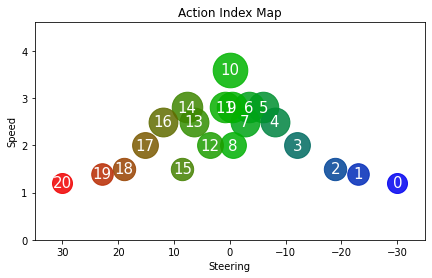

In [21]:
plot_index_map(asl)    

# Analysing data from all episodes

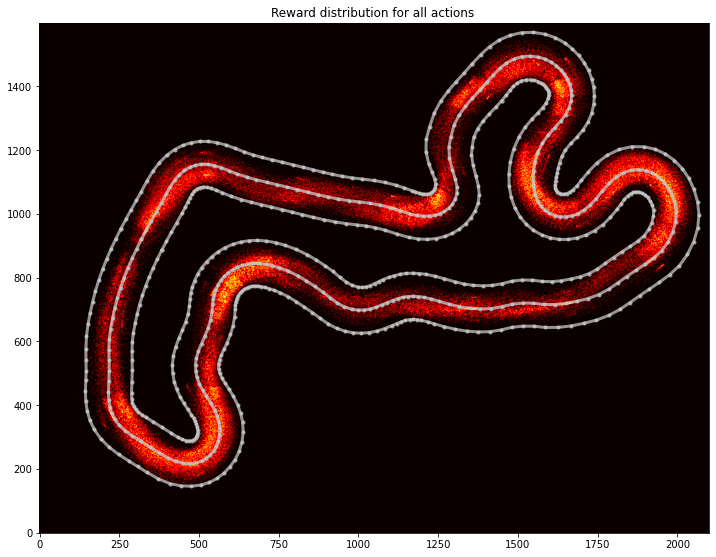

<Figure size 432x288 with 0 Axes>

In [22]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

Histograms for all episodes:


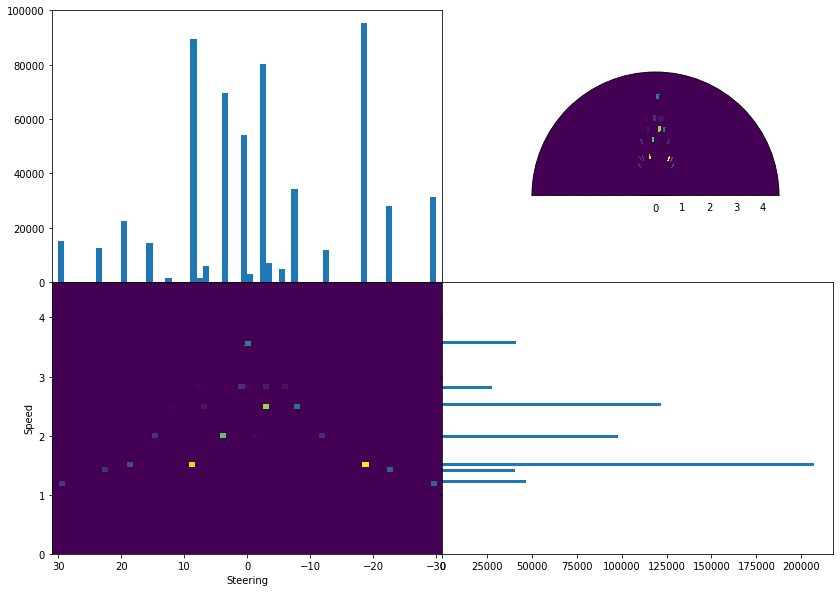

In [23]:
plot_4_hist(df)

Histogram for all episodes:


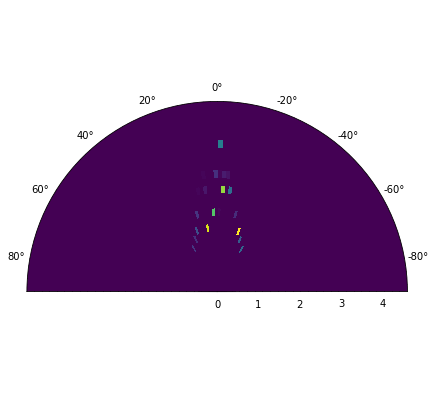

In [24]:
plot_polar_hist(df)



# Analyzing specific iteration





In [25]:
# Set iteration id
#itr = 12                      # iteration id
itr=df['iteration'].max()-1     # last iteration

In [26]:
df

iteration  episode  steps       x       y      yaw  steer  throttle  \
0               1        0      3 -7.2383  0.8779  62.0902    0.9       2.8   
1               1        0      4 -7.2220  0.9078  61.9976    7.7       2.8   
2               1        0      5 -7.1843  0.9928  63.4616    0.9       2.8   
3               1        0      6 -7.1279  1.1219  64.9350    0.0       3.6   
4               1        0      7 -7.0801  1.2281  65.2387   -6.0       2.8   
...           ...      ...    ...     ...     ...      ...    ...       ...   
582734        179     7146     52  7.8119  3.5706  45.0868  -30.0       1.2   
582735        179     7146     53  7.9226  3.6520  40.8971  -18.9       1.5   
582736        179     7146     54  7.9946  3.6950  37.6527  -18.9       1.5   
582737        179     7146     55  8.1670  3.7725  29.6449   -2.7       2.5   
582738        179     7146     56  8.3004  3.8157  23.9288  -18.9       1.5   

        action  reward  done on_track  progress  closest_waypoint  track_len  \
0         11.0  2.3354     0     True    0.3212                 1      60.27   
1         14.0  2.3557     0     True    0.3778                 1      60.27   
2         11.0  2.3621     0     True    0.5317                 1      60.27   
3         10.0  2.3676     0     True    0.7644                 1      60.27   
4          5.0  2.3648     0     True    0.9569                 2      60.27   
...        ...     ...   ...      ...       ...               ...        ...   
582734     0.0  0.0040     0    False   14.0634               103      60.27   
582735     2.0  0.0040     0    False   14.0634               103      60.27   
582736     2.0  0.0040     0    False   14.1077               103      60.27   
582737     7.0  0.0040     0    False   14.4030               104      60.27   
582738     2.0  0.0040     1    False   14.4652               104      60.27   

                 timestamp  new_reward  
0         1607063109.88953      2.3354  
1       1607063109.9859853      2.3557  
2       1607063110.0940075      2.3621  
3       1607063110.1930404      2.3676  
4       1607063110.3125172      2.3648  
...                    ...         ...  
582734   1607133570.140528      0.0040  
582735  1607133570.2267997      0.0040  
582736  1607133570.3360803      0.0040  
582737  1607133570.4455726      0.0040  
582738  1607133570.5284193      0.0040  

[582739 rows x 17 columns]

Iteration: 178


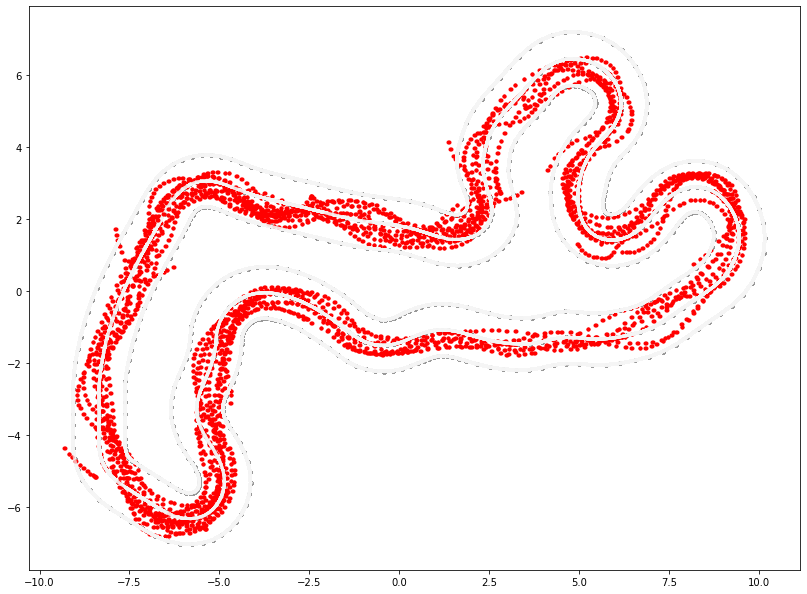

In [27]:
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)    

Histograms for iteration: 178


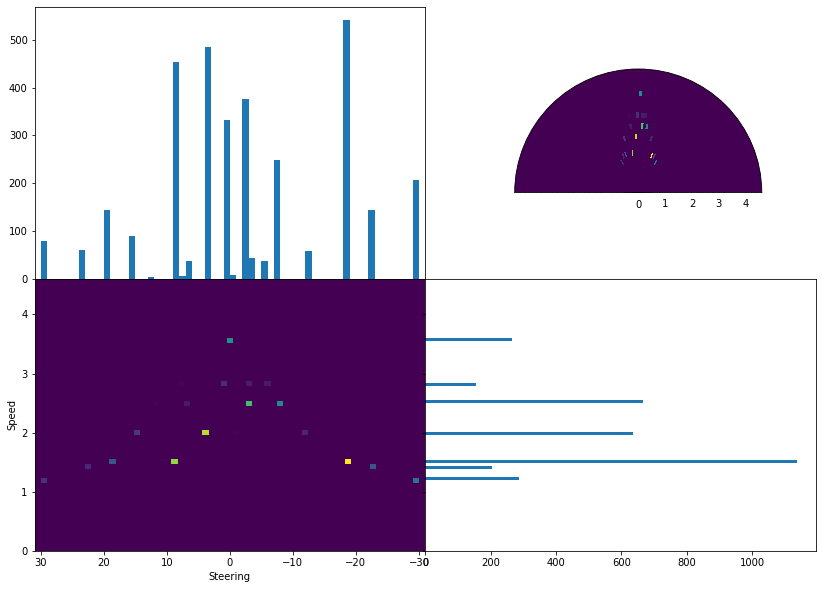

In [28]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 178


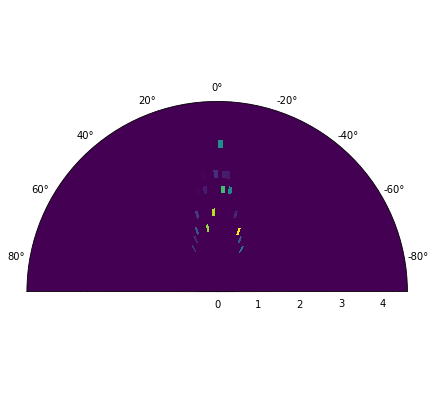

In [29]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [30]:
### choose episode id
#EPZ = 15
EPZ = df['episode'].max()
ITZ = df['iteration'].max()-1
#EPZ = 60
#EPZ = 442

<AxesSubplot:>

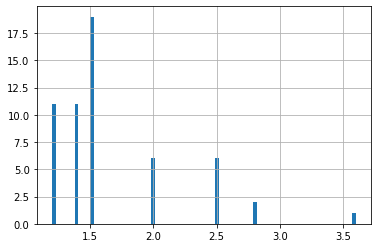

In [31]:
df[df['episode']==EPZ]['throttle'].hist(bins=80)

<AxesSubplot:>

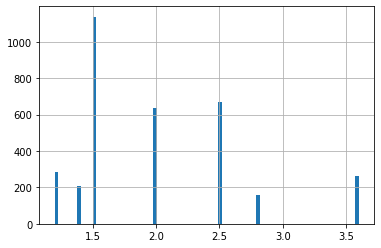

In [32]:
df[df['iteration']==ITZ]['throttle'].hist(bins=80)

<AxesSubplot:>

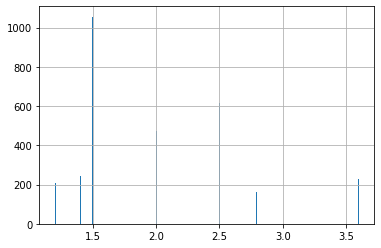

In [33]:
df[df['iteration']==20]['throttle'].hist(bins=300)

<AxesSubplot:>

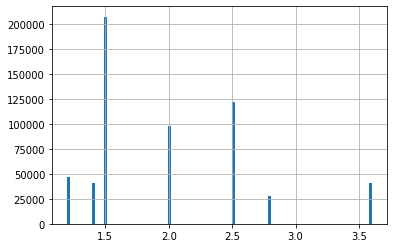

In [34]:
df['throttle'].hist(bins=100)

<AxesSubplot:>

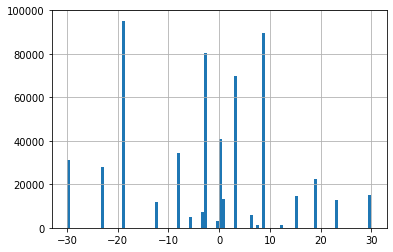

In [35]:
df['steer'].hist(bins=100)

In [36]:
df['throttle'].mean()

1.9712066637028798

In [37]:
df.groupby("iteration").mean()

episode       steps         x         y        yaw     steer  \
iteration                                                                     
1            18.592060   36.929804 -0.307202  0.314055 -11.901251 -2.602071   
2            59.060326   76.719914 -0.123217  0.551166  -9.746729 -2.800769   
3            98.972787   79.991204  0.022966  0.340927 -13.072604 -2.974437   
4           140.635838   52.556840 -0.449280  0.168490 -12.246425 -2.601503   
5           179.031085   73.821573 -0.389495  0.324933 -10.845287 -2.368449   
6           218.799822   76.112100 -0.614520  0.244737  -3.823790 -2.634964   
7           259.194497   85.232333  0.407801  0.457804 -15.441158 -3.196685   
8           300.197057   74.518465 -0.081630  0.453305  -6.201962 -2.449163   
9           338.902932   79.647204  0.782796  0.588729 -13.746359 -2.583296   
10          377.394982   90.270564 -0.044392  0.543339  -7.650186 -2.709286   
11          419.860806   67.787546 -0.546785  0.016036 -12.787727 -2.686813   
12          456.839067   70.431195  0.280626  0.611992 -11.579170 -2.438163   
13          500.257828   71.044637 -0.520002  0.285479 -11.475006 -2.640839   
14          539.766816   70.300448  0.834585  0.676413 -15.128848 -2.660058   
15          579.876046   68.811877  0.698970  0.359673 -16.901139 -2.362136   
16          619.491153   79.095442  0.521536  0.969181  -7.975690 -2.600912   
17          658.758028   59.296464 -0.649473  0.570305  -5.728268 -2.684398   
18          701.317220   68.735229 -0.699815  0.240288  -5.824962 -2.753270   
19          740.836066   45.880048 -0.558860  0.073275 -13.205590 -2.744542   
20          782.824338   61.675494 -0.631084  0.429102  -9.913557 -2.205565   
21          819.068801   73.350183  0.016239  0.692035  -7.232826 -2.725583   
22          859.188207   67.061707 -0.776901  0.181205 -10.602412 -2.785087   
23          900.601071   66.744311 -0.843997 -0.044143  -8.454106 -3.072256   
24          940.398925   80.653927  0.573697  0.755015  -8.568163 -2.599074   
25          977.096034   55.452955  0.197115  0.479982 -15.904967 -2.376788   
26         1017.044330   77.240283  0.712849  0.783561 -13.916617 -2.181690   
27         1058.378882   52.218168  0.064404  0.325606 -15.579551 -2.846157   
28         1102.509729   66.441816  0.653492  0.424204 -19.376023 -2.773598   
29         1139.802022   64.364238 -1.046963  0.128052  -8.744477 -3.178808   
30         1180.438511   59.717563 -0.066631  0.350918 -15.070964 -2.916660   
31         1219.271777   73.712834  0.215078  0.691747  -6.803381 -2.916986   
32         1260.591584   63.090523 -0.859095 -0.196012  -8.117327 -2.603395   
33         1297.514556   69.684688 -0.558579  0.476768  -8.861207 -2.646087   
34         1335.673168   79.804124  0.512843  0.638119 -13.842631 -2.854751   
35         1380.832041   63.353144 -0.102114  0.518146  -6.687666 -3.160867   
36         1419.659893   85.150267 -0.335547  0.180908 -13.797740 -2.674171   
37         1460.557626   62.737060 -0.329301  0.068954 -11.804168 -3.290890   
38         1499.447080   62.976642 -0.610073  0.600471  -1.215064 -2.735584   
39         1538.231848   70.426868 -0.449592 -0.070825 -11.836100 -2.843108   
40         1577.095413   68.632072  0.514918  0.467547 -16.775593 -2.831369   
41         1620.022597   55.968365 -0.653545  0.002838 -15.023061 -3.053246   
42         1659.377565   71.566843  0.255644  0.540457 -11.740606 -2.791694   
43         1700.810837   72.805133  0.859868  0.789427 -16.068840 -2.583143   
44         1741.324477   81.526033  0.013938  0.425367 -10.443048 -2.398148   
45         1776.778552   71.932142 -0.183021  0.137665 -12.677533 -2.586368   
46         1821.257469   87.237204  0.283510  0.587561  -8.868027 -2.662198   
47         1860.213094   74.728045 -0.011928  0.441272 -10.109615 -2.467296   
48         1897.647217   67.730382 -0.913289 -0.203658  -8.843619 -2.772300   
49         1941.070057   56.855974  0.293697  0.607411  -9.341599

In [38]:
(df[df['on_track']=='False'].groupby("closest_waypoint").count() / df[df['on_track']=='False'].count()["iteration"]) ['iteration']


closest_waypoint
0      0.000969
1      0.004422
2      0.006785
3      0.007330
4      0.007209
5      0.006118
6      0.006361
7      0.005210
8      0.004846
9      0.004967
10     0.003877
11     0.004362
12     0.004240
13     0.002847
14     0.003271
15     0.003150
16     0.004119
17     0.005088
18     0.006421
19     0.009147
20     0.012479
21     0.012297
22     0.009935
23     0.005937
24     0.003211
25     0.002908
26     0.003392
27     0.003756
28     0.002302
29     0.001636
30     0.002181
31     0.001999
32     0.003513
33     0.002726
34     0.002787
35     0.002787
36     0.002968
37     0.003332
38     0.003453
39     0.003877
40     0.002605
41     0.002120
42     0.002484
43     0.002908
44     0.003937
45     0.010540
46     0.020233
47     0.009511
48     0.004362
49     0.005391
50     0.007875
51     0.008360
52     0.005452
53     0.002302
54     0.001696
55     0.003029
56     0.001938
57     0.001696
58     0.004664
59     0.005876
60     0.006239
61     

In [39]:
df.groupby("closest_waypoint").mean()

iteration      episode      steps         x         y  \
closest_waypoint                                                          
0                 90.897260  3614.748043  53.537671 -7.311096  0.814212   
1                 91.703780  3647.874417  60.358105 -7.213715  1.007902   
2                 90.706712  3609.717438  70.829298 -7.068326  1.313244   
3                 91.145582  3627.479657  76.084552 -6.909131  1.606620   
4                 91.985536  3661.347460  76.951900 -6.747144  1.889888   
5                 91.003642  3621.946103  78.382739 -6.600469  2.149919   
6                 91.685151  3649.202084  81.507629 -6.448872  2.375735   
7                 91.216227  3630.650233  81.521739 -6.284937  2.560403   
8                 90.558957  3604.303269  83.829954 -6.125876  2.717808   
9                 92.190217  3669.294384  84.038949 -5.953148  2.827963   
10                90.440223  3599.420973  84.059271 -5.788201  2.915515   
11                91.798883  3653.491620  83.771965 -5.615183  2.966785   
12                91.342466  3631.396926  54.732041 -5.431689  3.026335   
13                91.407850  3635.232150  65.213458 -5.257409  2.989996   
14                91.809084  3651.784065  69.560816 -5.056926  2.955888   
15                91.741851  3649.524916  74.282128 -4.842686  2.892496   
16                91.007279  3620.467591  75.773657 -4.612035  2.783877   
17                91.920283  3657.192982  79.623884 -4.360058  2.624315   
18                91.096607  3624.253882  81.154112 -4.082804  2.456134   
19                91.427906  3637.334430  83.457237 -3.786419  2.300321   
20                91.850852  3654.397443  83.963636 -3.474378  2.186330   
21                91.837562  3653.779528  85.970254 -3.153100  2.125295   
22                91.113411  3624.539454  84.512751 -2.816518  2.104217   
23                91.314975  3629.892327  56.979373 -2.468522  2.175660   
24                90.965132  3617.275402  73.260692 -2.123788  2.166205   
25                91.284739  3630.131532  76.517815 -1.783673  2.166658   
26                90.750879  3609.115446  80.148385 -1.451996  2.148416   
27                90.564389  3601.429041  81.862352 -1.127251  2.099297   
28                91.381641  3634.262946  83.696369 -0.805568  2.028006   
29                90.987467  3618.451187  85.925462 -0.488506  1.923998   
30                92.061325  3661.434553  86.478075 -0.169949  1.817654   
31                91.144879  3624.489218  86.525943  0.140672  1.695705   
32                91.455509  3635.098035  56.895562  0.459415  1.635524   
33                91.678211  3645.030270  73.326970  0.770443  1.535687   
34                92.395196  3673.883843  77.527476  1.071749  1.490793   
35                92.346912  3671.891809  80.080158  1.310861  1.486398   
36                92.892180  3693.711245  81.070338  1.506085  1.517562   
37                92.869985  3692.734891  83.265109  1.677803  1.568097   
38                93.636631  3723.590106  83.971731  1.824777  1.634158   
39                93.502729  3717.789222  85.171896  1.948875  1.698511   
40                94.475904  3756.911898  82.120482  2.063768  1.767484   
41                93.739394  3727.316883  83.526407  2.164722  1.849356   
42                94.962591  3775.772810  83.325730  2.246124  1.944530   
43                95.918095  3813.565714  79.923810  2.360329  2.037669   
44                94.066007  3739.632838  76.832508  2.425626  2.176521   
45                94.034704  3738.240790  79.680192  2.390720  2.353668   
46                91.669428  3643.056951  56.052809  2.401424  2.599215   
47                92.547340  3678.872306  67.413643  2.346783  2.874842   
48                92.676508  3684.229841  75.508254  2.273136  3.231926   
49                93.355788  3711.682145  81.454872  2.180651  3.607247   
50                93.034600  3698.460303  82.128514  2.205831  3.975652   
51                93.577956  3720.220714  8

In [40]:
df[['iteration', 'steer', 'throttle']].groupby("iteration").mean()

steer  throttle
iteration                    
1         -2.602071  1.991715
2         -2.800769  1.968914
3         -2.974437  1.952996
4         -2.601503  1.983353
5         -2.368449  1.946192
6         -2.634964  2.002372
7         -3.196685  1.979487
8         -2.449163  1.978563
9         -2.583296  1.921754
10        -2.709286  1.960683
11        -2.686813  2.020696
12        -2.438163  1.956501
13        -2.640839  1.927781
14        -2.660058  1.981134
15        -2.362136  1.967836
16        -2.600912  1.929276
17        -2.684398  1.956925
18        -2.753270  2.016335
19        -2.744542  1.984886
20        -2.205565  1.986490
21        -2.725583  1.950183
22        -2.785087  2.014296
23        -3.072256  2.029585
24        -2.599074  1.945028
25        -2.376788  1.994984
26        -2.181690  1.988693
27        -2.846157  1.951009
28        -2.773598  1.906944
29        -3.178808  2.024712
30        -2.916660  1.947386
31        -2.916986  1.959001
32        -2.603395  1.995085
33        -2.646087  1.992590
34        -2.854751  1.953469
35        -3.160867  1.963107
36        -2.674171  1.965348
37        -3.290890  2.005797
38        -2.735584  1.990912
39        -2.843108  1.982112
40        -2.831369  1.949648
41        -3.053246  1.980033
42        -2.791694  1.942124
43        -2.583143  1.925475
44        -2.398148  1.962668
45        -2.586368  1.992063
46        -2.662198  1.948558
47        -2.467296  1.950740
48        -2.772300  1.966633
49        -2.295341  1.932610
50        -2.408150  1.940439
51        -2.419959  1.949011
52        -2.722453  1.941178
53        -2.999574  1.933902
54        -2.791410  1.971805
55        -2.998506  1.954062
56        -2.586938  1.926407
57        -3.163533  1.968957
58        -2.460490  1.960270
59        -2.224601  1.940950
60        -2.871824  1.955807
61        -3.249465  1.967264
62        -2.531945  1.969922
63        -3.065658  1.966600
64        -2.951106  1.964548
65        -2.118305  1.935684
66        -2.911343  1.933072
67        -3.065736  1.940708
68        -2.525035  1.971226
69        -2.894571  1.993111
70        -3.490000  1.970571
71        -2.711394  1.979891
72        -2.643278  1.950080
73        -2.261178  1.942588
74        -2.896776  2.050233
75        -2.519504  1.981190
76        -2.586273  1.973547
77        -2.337253  1.977174
78        -2.304640  1.974240
79        -2.987489  1.963575
80        -2.447323  2.012659
81        -2.418389  1.977120
82        -2.641097  1.958844
83        -2.912797  1.960851
84        -2.865882  1.955418
85        -2.005969  1.919825
86        -3.200064  1.959751
87        -2.580519  1.992489
88        -2.464333  1.963640
89        -2.837199  1.952663
90        -2.388885  2.008244
91        -3.011528  1.930585
92        -2.784529  1.972686
93        -2.252346  1.965931
94        -2.847098  1.947932
95        -2.043285  1.981811
96        -2.606940  1.995031
97        -2.721674  1.978415
98        -2.672209  1.967864
99        -2.768167  1.977784
100       -2.365538  1.989978
101       -2.770414  1.968454
102       -3.097214  1.934506
103       -3.055630  1.979540
104       -2.807308  1.913310
105       -2.742365  1.982440
106       -3.243538  1.937001
107       -2.820468  1.938488
108       -2.736231  1.933718
109       -2.632823  1.962318
110       -3.075881  1.968451
111       -2.500232  1.971719
112       -2.318737  1.970674
113       -2.621375  1.964321
114       -2.342759  1.968923
115       -2.687247  1.976282
116       -2.639475  1.954238
117       -2.495224  1.953054
118       -2.875914  1.955595
119       -2.483531  1.999091
120       -3.023255  1.912718
121       -2.670529  1.935264
122       -2.384957  1.946048
123       -2.687471  1.968645
124       -3.216749  1.967560
125       -2.536098  1.950241
126       -3.222451  1.937805
127       -2.713217  2.007249
128       -2.179010  1.975740
129       -2.807172  1.995426
130       -2.590696  1.938063
131       -2.872785  1.931573
132       -2.529235  2.0

In [41]:
df[df['episode']==EPZ]

iteration  episode  steps       x       y       yaw  steer  throttle  \
582683        179     7146      1  5.7510  6.1045  -36.1561  -30.0       1.2   
582684        179     7146      2  5.7602  6.0964  -36.4366  -23.0       1.4   
582685        179     7146      3  5.7824  6.0755  -37.3306  -23.0       1.4   
582686        179     7146      4  5.8162  6.0400  -39.1324  -23.0       1.4   
582687        179     7146      5  5.8671  5.9700  -43.9663  -23.0       1.4   
582688        179     7146      6  5.9304  5.8696  -49.7980  -23.0       1.4   
582689        179     7146      7  5.9926  5.7534  -55.2736  -23.0       1.4   
582690        179     7146      8  6.0437  5.6323  -60.7727  -12.1       2.0   
582691        179     7146      9  6.0733  5.5387  -65.0395  -23.0       1.4   
582692        179     7146     10  6.1066  5.3642  -73.2181  -12.1       2.0   
582693        179     7146     11  6.1139  5.1972  -81.1936    0.0       3.6   
582694        179     7146     12  6.0934  4.9891  -90.7187   -8.0       2.5   
582695        179     7146     13  6.0466  4.7917  -98.9909   -8.0       2.5   
582696        179     7146     14  5.9857  4.6275 -105.7680   -3.4       2.8   
582697        179     7146     15  5.8233  4.3054 -115.8203   -2.7       2.5   
582698        179     7146     16  5.7182  4.1359 -119.6445    0.9       2.8   
582699        179     7146     17  5.5598  3.9038 -123.3247    3.6       2.0   
582700        179     7146     18  5.4467  3.7433 -124.5283    8.5       1.5   
582701        179     7146     19  5.2969  3.5068 -122.6622   19.0       1.5   
582702        179     7146     20  5.2215  3.3496 -118.5221    8.5       1.5   
582703        179     7146     21  5.1556  3.1690 -113.3201    8.5       1.5   
582704        179     7146     22  5.1194  3.0209 -108.3901   30.0       1.2   
582705        179     7146     23  5.1052  2.9027 -103.3835    8.5       1.5   
582706        179     7146     24  5.1054  2.7675  -97.0896   23.0       1.4   
582707        179     7146     25  5.1313  2.5730  -88.0070  -23.0       1.4   
582708        179     7146     26  5.1587  2.4670  -83.1624   30.0       1.2   
582709        179     7146     27  5.2186  2.3013  -75.6510    8.5       1.5   
582710        179     7146     28  5.2536  2.2318  -71.9240    8.5       1.5   
582711        179     7146     29  5.3647  2.0640  -62.5261   23.0       1.4   
582712        179     7146     30  5.4218  1.9932  -58.6198   19.0       1.5   
582713        179     7146     31  5.5759  1.8482  -48.7344   23.0       1.4   
582714        179     7146     32  5.6800  1.7756  -42.5644   30.0       1.2   
582715        179     7146     33  5.8183  1.7080  -33.9984   19.0       1.5   
582716        179     7146     34  5.9075  1.6789  -28.4204   19.0       1.5   
582717        179     7146     35  6.0978  1.6532  -15.9014   19.0       1.5   
582718        179     7146     36  6.2218  1.6540   -8.7561   30.0       1.2   
582719        179     7146     37  6.3672  1.6747   -0.3418   19.0       1.5   
582720        179     7146     38  6.5142  1.7215    9.0930   19.0       1.5   
582721        179     7146     39  6.6415  1.7934   19.3068   15.2       2.0   
582722        179     7146     40  6.7467  1.8731   27.5749    3.6       2.0   
582723        179     7146     41  6.8699  1.9992   38.1920   15.2       2.0   
582724        179     7146     42  7.0014  2.1739   48.1559   -8.0       2.5   
582725        179     7146     43  7.1097  2.3635   56.2140   -8.0       2.5   
582726        179     7146     44  7.1583  2.4702   60.3183  -18.9       1.5   
582727        179     7146     45  7.2515  2.7070   67.3574    8.5       1.5   
582728        179     7146     46  7.3286  2.9092   68.9286  -18.9       1.5   
582729        179     7146     47  7.3964  3.0826   68.5789  -30.0       1.2   
582730        179     7146     48  7.4631  3.2093   65.3918  -30.0       1.2   
582731        179     7146     49  7.5573  3.3343   58.7684   30.0       1.2   
582732  

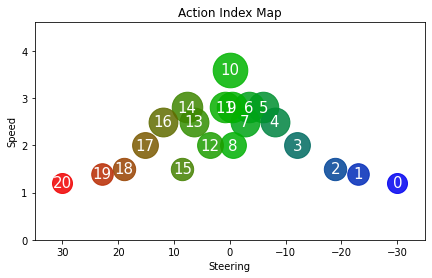

In [42]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


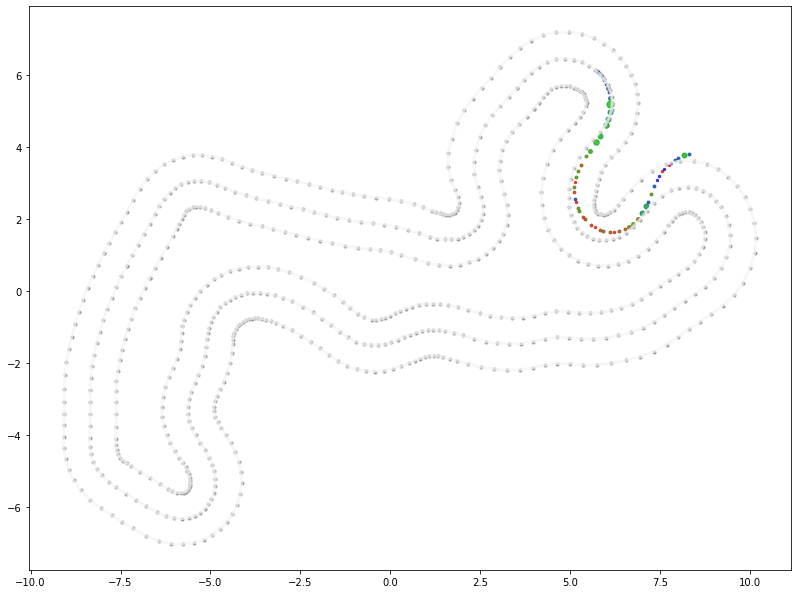

In [43]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
#EPZ = 31
plot_episode_color(df,EPZ) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 7146


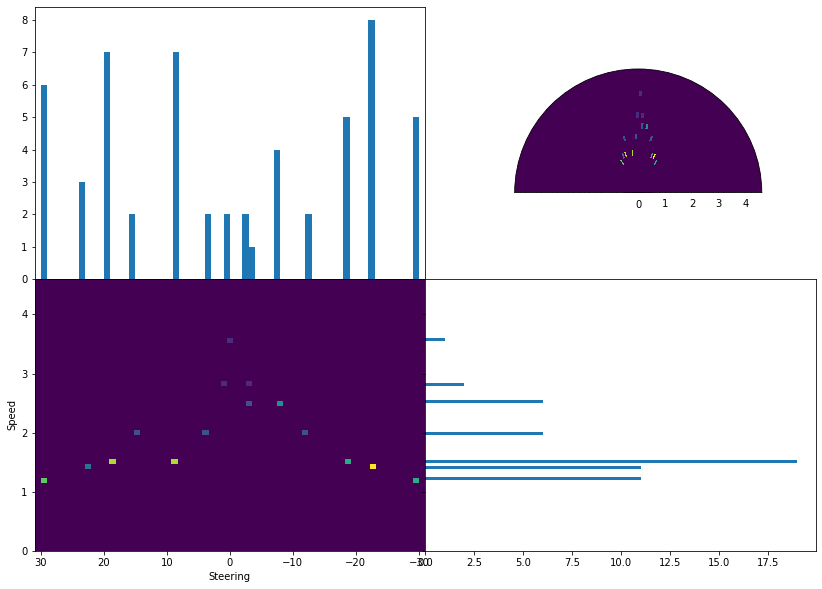

In [44]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 7146


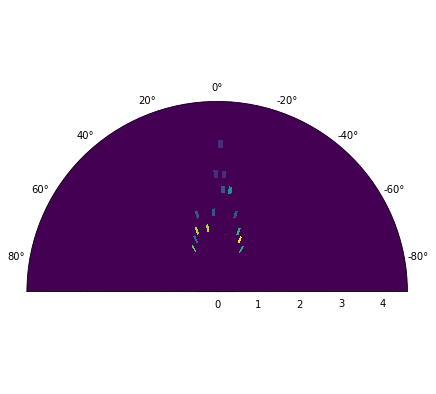

In [45]:
plot_polar_hist(df, E = EPZ)

<AxesSubplot:xlabel='closest_waypoint'>

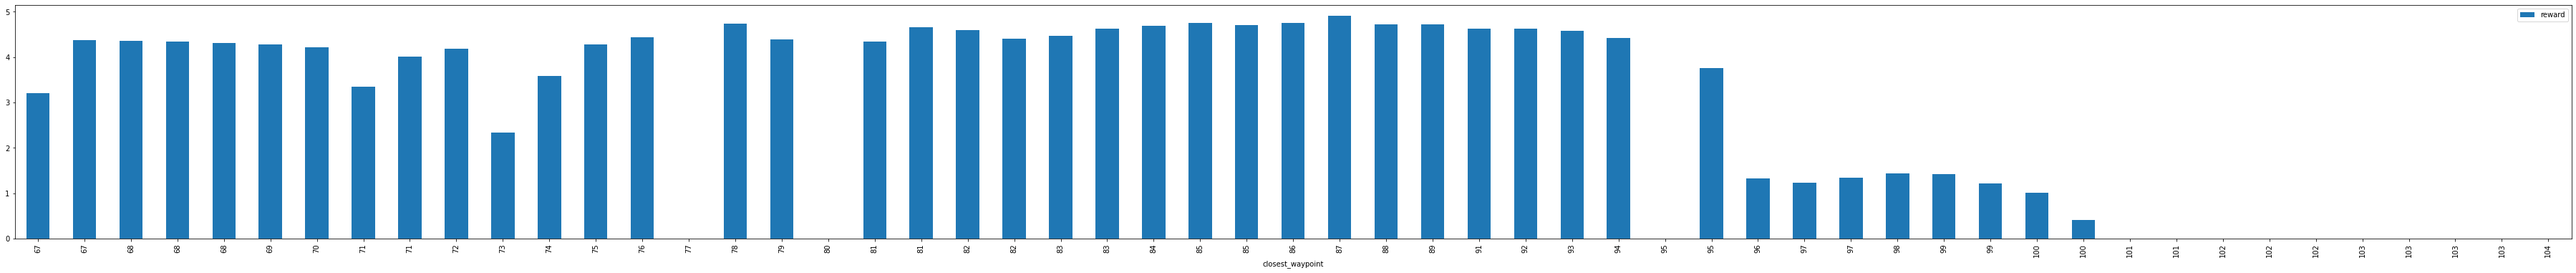

In [46]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==EPZ]
episode[:-1].plot.bar(x='closest_waypoint', y='reward',figsize=(64, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: -30.0, throttle: 1.2


<Figure size 432x288 with 0 Axes>

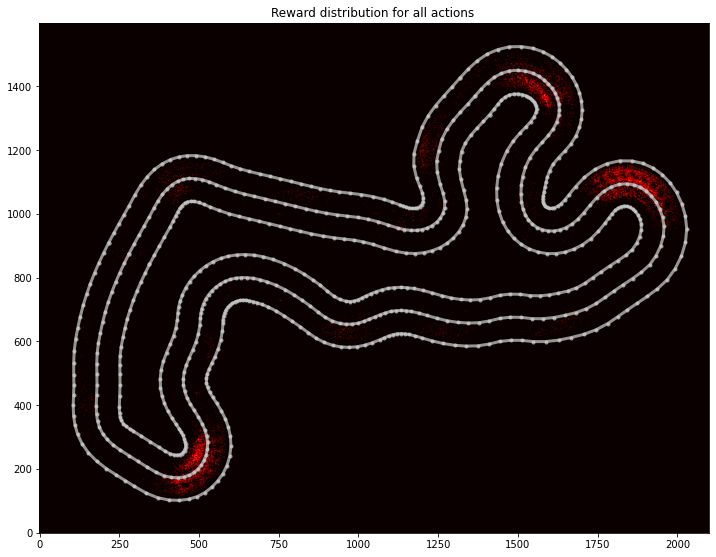

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 1: steering: -23.0, throttle: 1.4


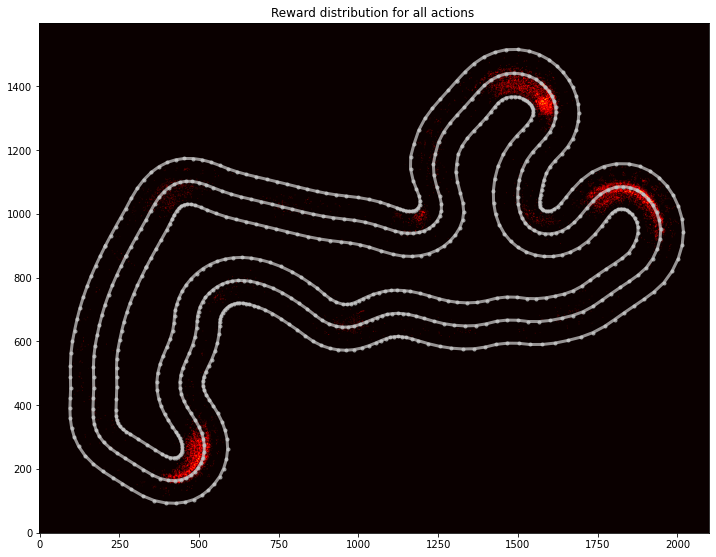

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 2: steering: -18.9, throttle: 1.5


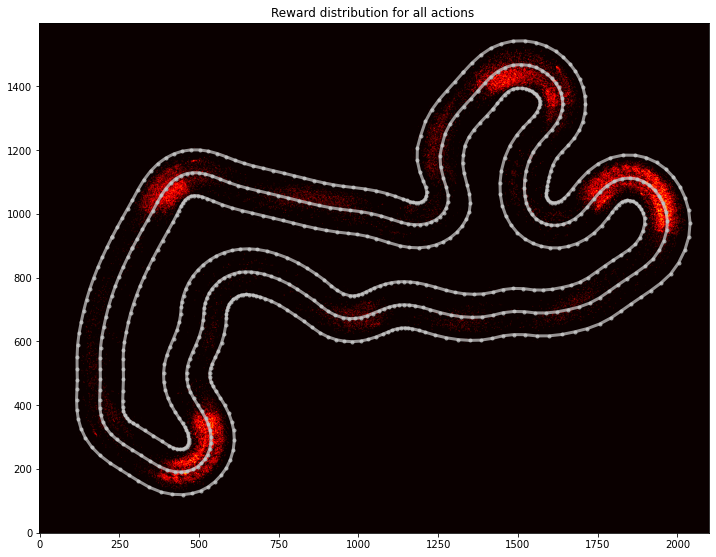

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 3: steering: -12.1, throttle: 2.0


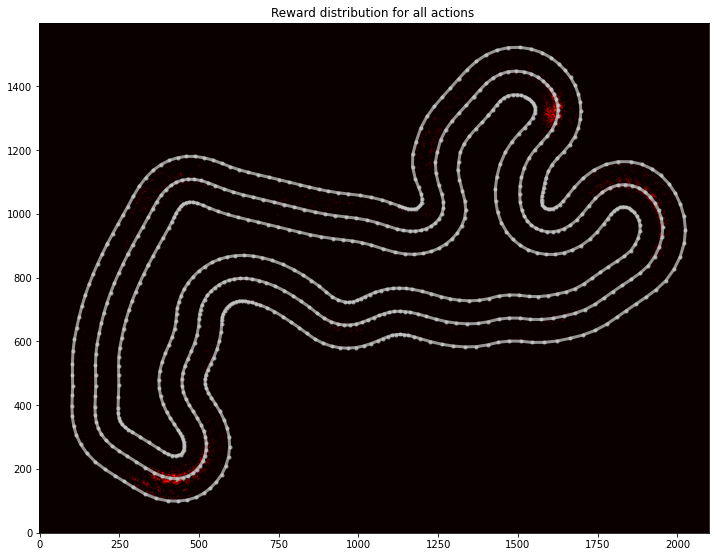

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 4: steering: -8.0, throttle: 2.5


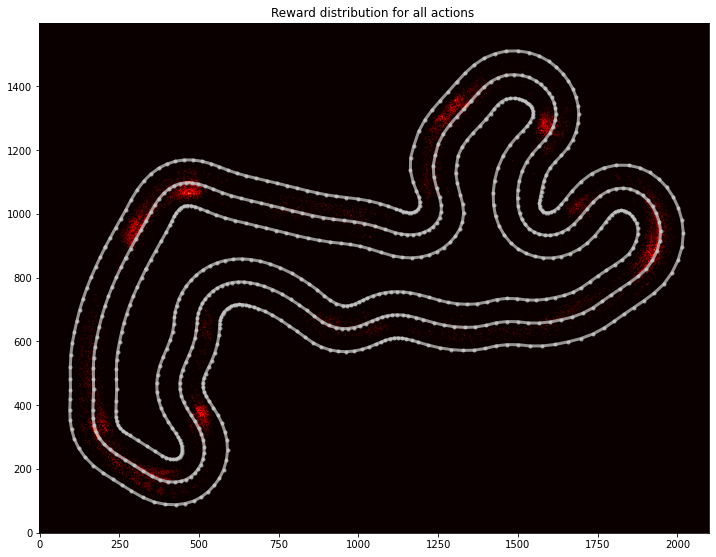

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 5: steering: -6.0, throttle: 2.8


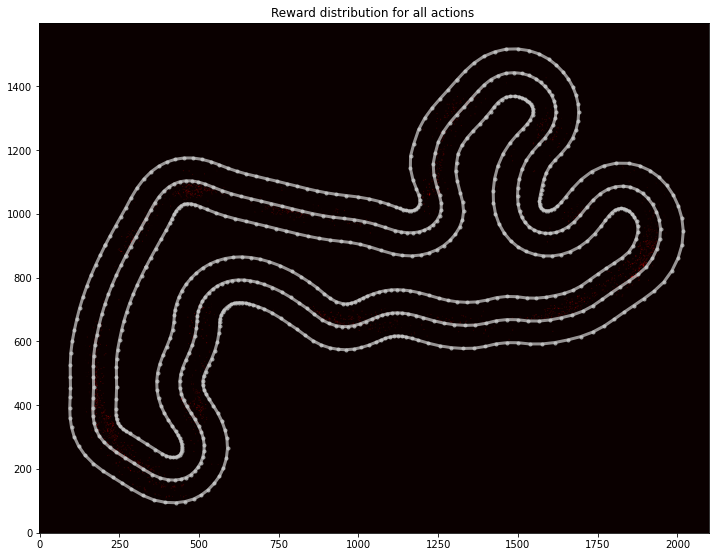

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 6: steering: -3.4, throttle: 2.8


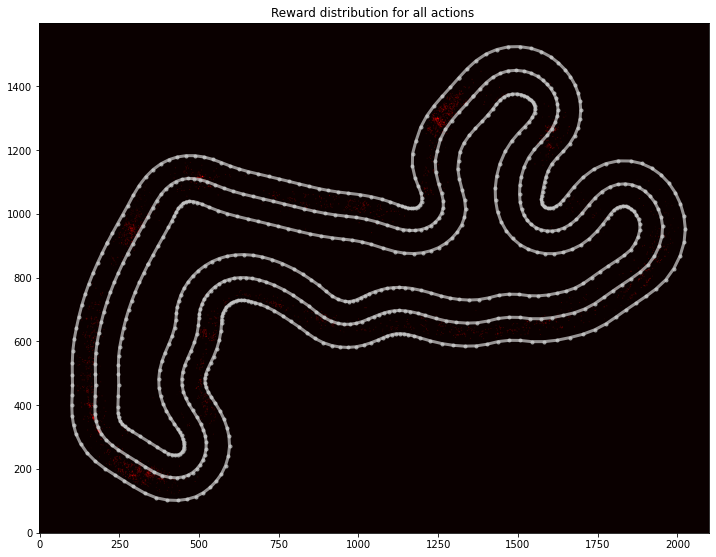

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 7: steering: -2.7, throttle: 2.5


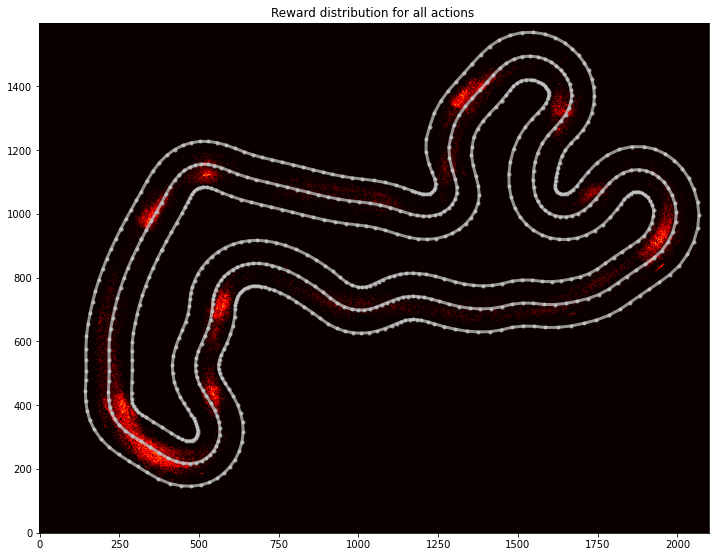

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 8: steering: -0.5, throttle: 2.0


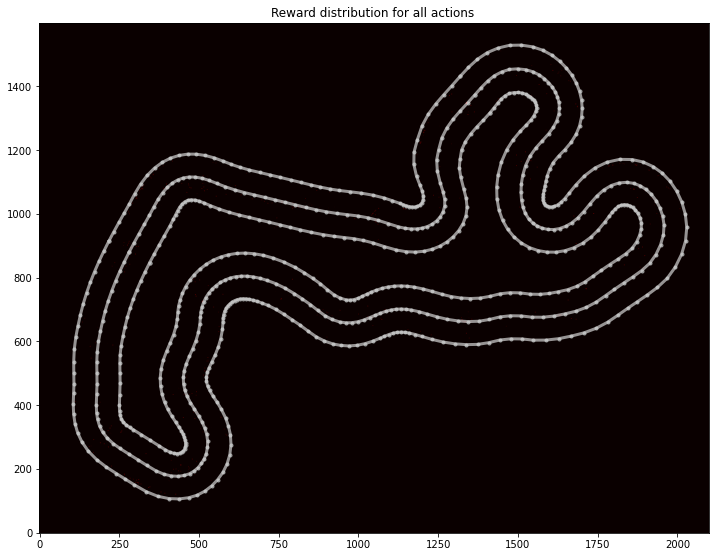

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 9: steering: -0.3, throttle: 2.8


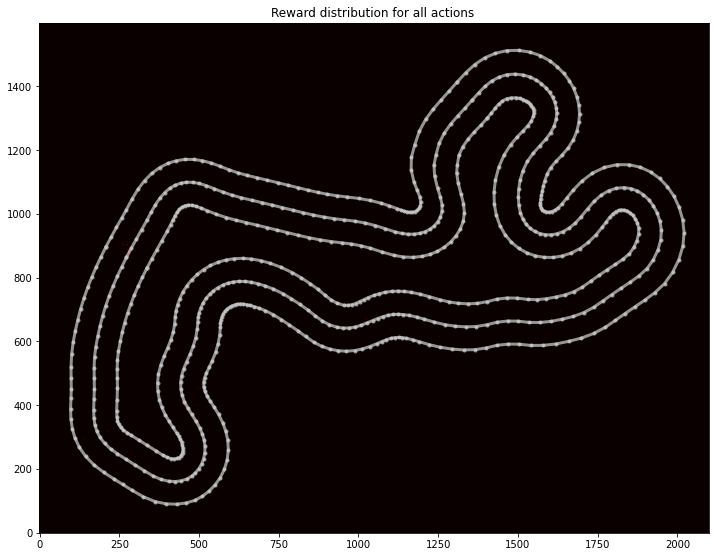

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 10: steering: 0.0, throttle: 3.6


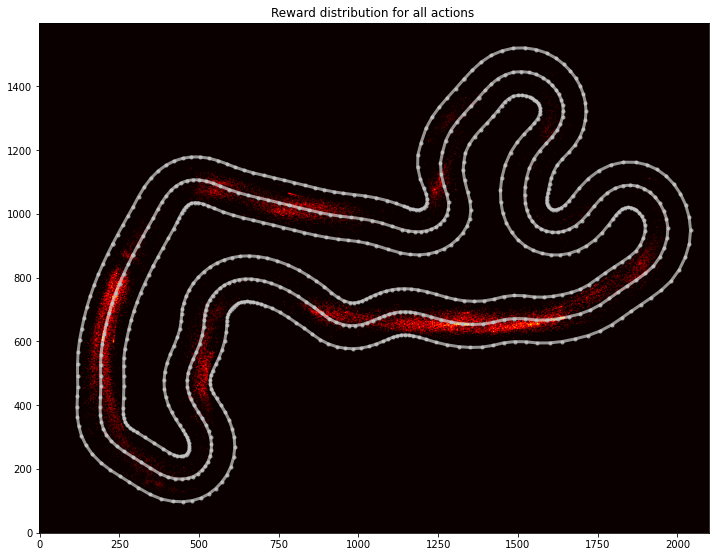

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 11: steering: 0.9, throttle: 2.8


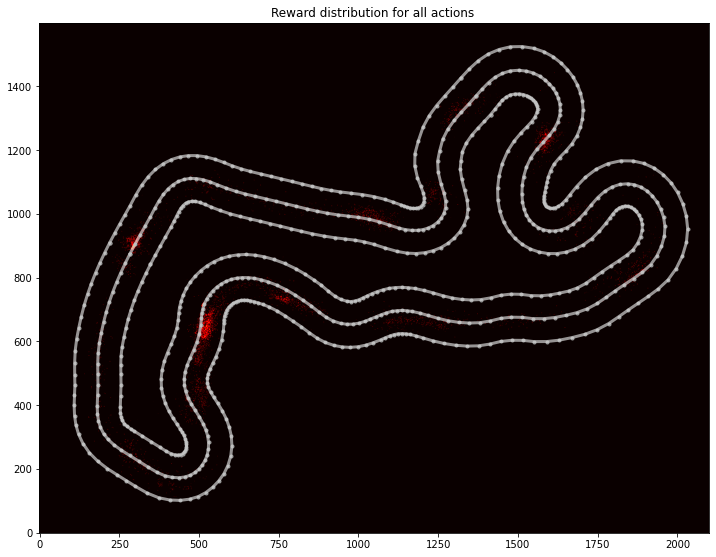

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 12: steering: 3.6, throttle: 2.0


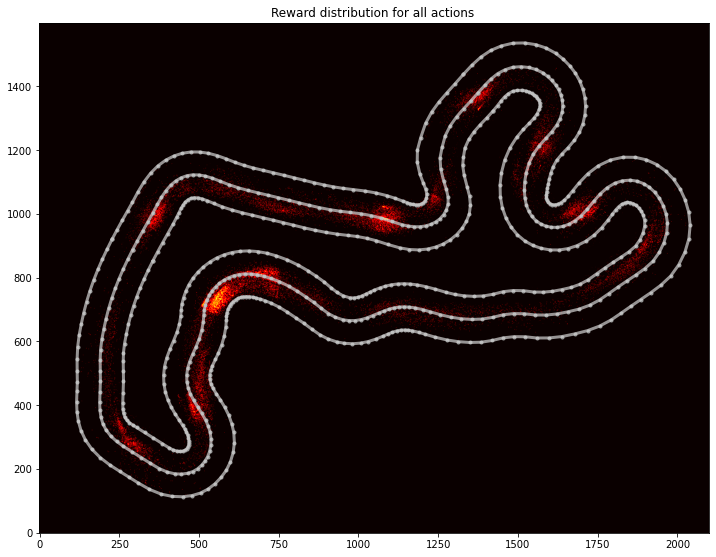

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 13: steering: 6.4, throttle: 2.5


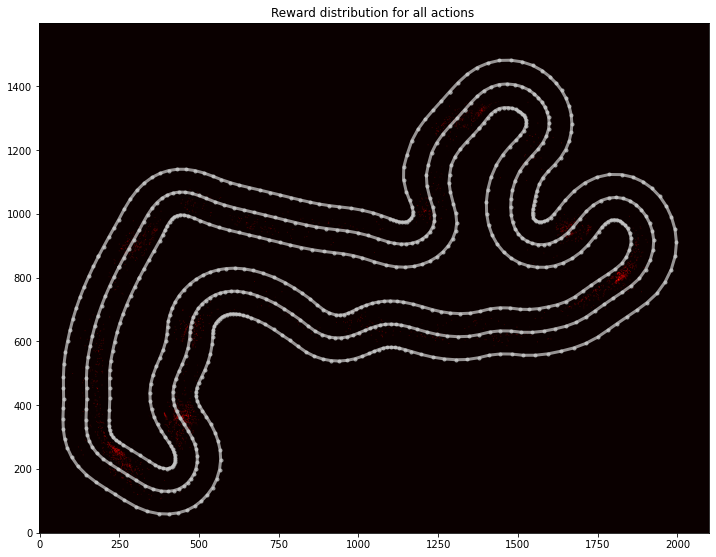

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 14: steering: 7.7, throttle: 2.8


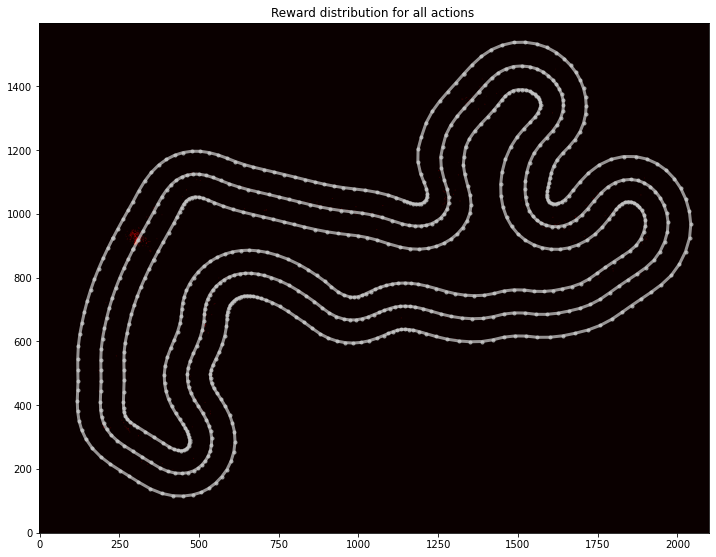

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 15: steering: 8.5, throttle: 1.5


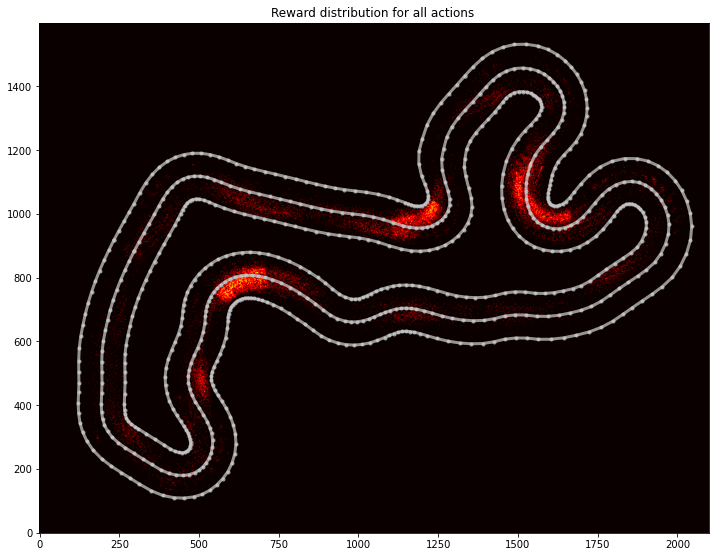

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 16: steering: 12.0, throttle: 2.5


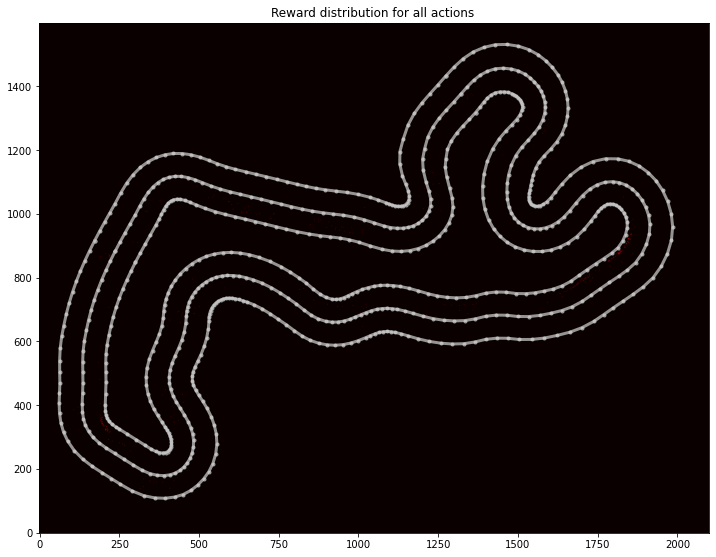

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 17: steering: 15.2, throttle: 2.0


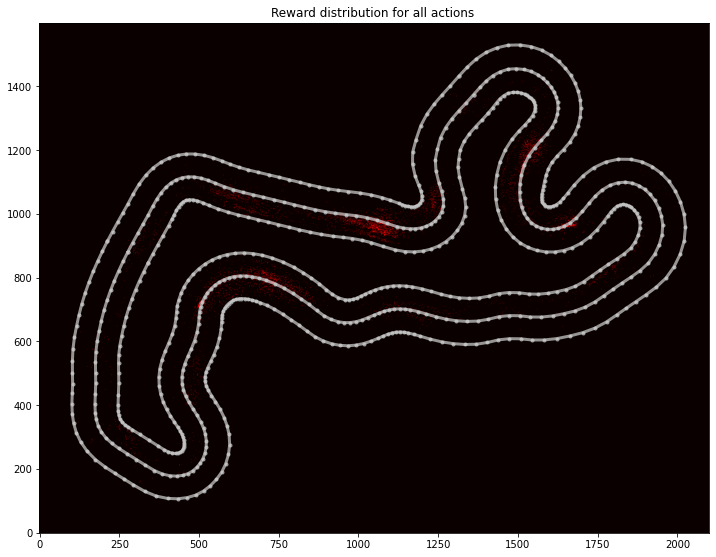

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 18: steering: 19.0, throttle: 1.5


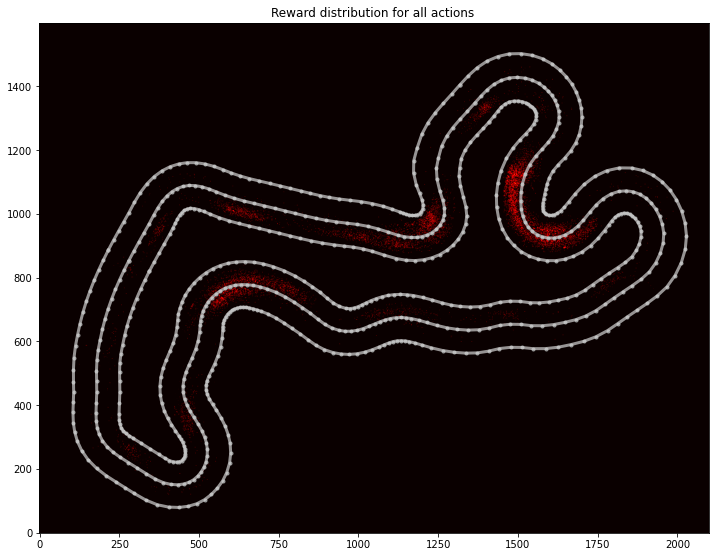

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 19: steering: 23.0, throttle: 1.4


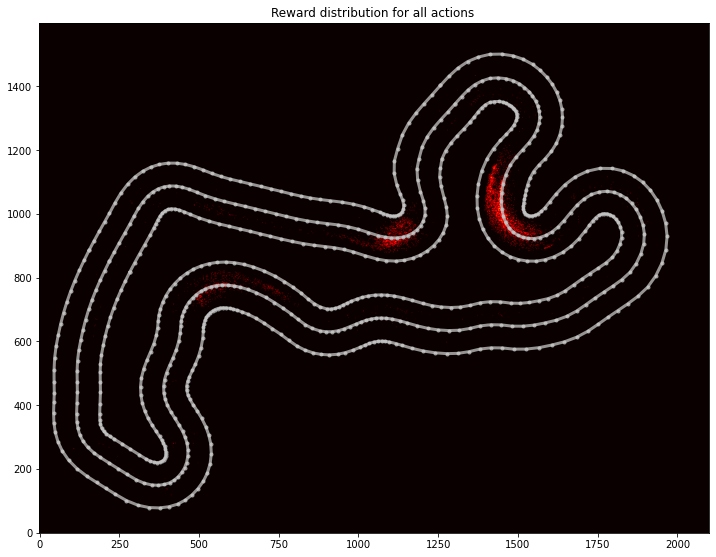

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 20: steering: 30.0, throttle: 1.2


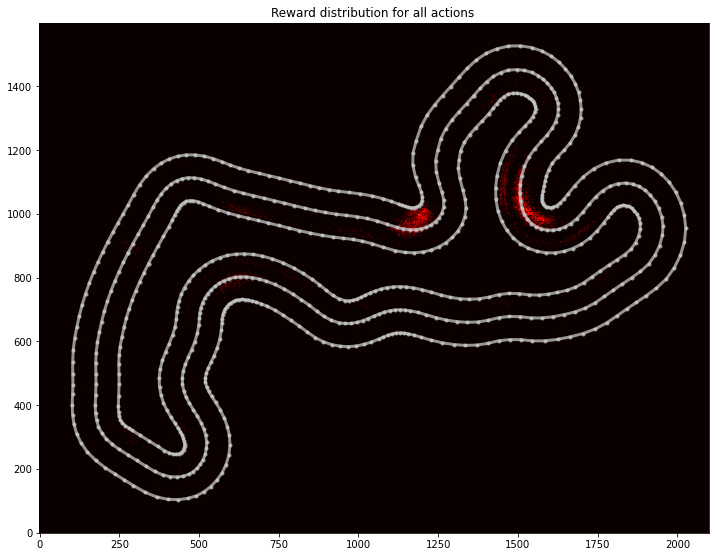

<Figure size 432x288 with 0 Axes>

In [47]:
aslNum = len(asl)
setActions = range(aslNum)     # show graphs for all Actions
#setActions = (0,1,6,8,9)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions: 
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer,a.throttle))
    tr_plot = pu.plot_track(df[df['action'] == a.index], track, value_field="reward") 
    plt.show()

In [48]:
#df[df['on_track']=='False'].count()[""]